# PFN and PFN with mdn layer
this note book is only for model training, see result comparison in PFN_eval.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time as t
import scipy.constants as spc
import matplotlib.ticker as ticker


In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
# ext_datapath = ext_path + "data_storage/STMC/"
ext_datapath = 'D:/Work/Datastorage/STMC/'
ext_plotpath = ext_path + "plots/"

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur
import keras.utils.io_utils as kiu
import h5py as h5
import tensorflow as tf

In [4]:
# load training data
with h5.File(ext_datapath+'STMC_full_1.h5', 'r') as hf:
    data = hf['X'][:]
    target = hf['Y'][:]

# load validation data
with h5.File(ext_datapath+'STMC_val.h5', 'r') as hf:
    val_data = hf['X'][:]
    val_target = hf['Y'][:]

In [5]:
print(data.shape)
print(target.shape)
print(val_data.shape)
print(val_target.shape)

(1277076, 1086, 5)
(1277076,)
(123588, 1086, 5)
(123588,)


Use data generator feed input data to avoid memory issue, any one of the three here should work, carefully choose the generator batch sizes would improve the gpu usage rate.

In [6]:
def minibatches(inputs=None, targets=None, batch_size=None, shuffle=False):
    while True:
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
        for start_idx in range( len(inputs) - batch_size ):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batch_size]
            else:
                excerpt = slice(start_idx, start_idx + batch_size)
            yield inputs[excerpt], targets[excerpt]

In [6]:
def data_generator(data, targets, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     while True:
          for i in range(batches):
               X = data[i*batch_size : (i+1)*batch_size]
               Y = targets[i*batch_size : (i+1)*batch_size]
               yield (X, Y)

ML Model setup

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as Kb
import energyflow as ef
from energyflow.archs import PFN

In [49]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 1000

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

RMS_prop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [50]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

Kb.clear_session()

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('pfn_regressor_30f_GN.h5', monitor='val_loss', verbose=1, save_best_only=True)
t0 = t.time()
history_ct = pfn.fit(minibatches(data, target, batch_size=2048, shuffle=True),
                    steps_per_epoch=len(data)//2048,
                    validation_data=(minibatches(val_data, val_target, batch_size=2048, shuffle=True)),
                    validation_steps=len(val_data)//2048,
                    epochs=1000,
                    verbose=1,
                    callbacks=[chkpoint])
t1 = t.time()
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str(t1-t0)/60+' (m)')

In [ ]:
physical_gpus = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_gpus[0],True)
logical_gpus = tf.config.list_logical_devices("GPU")

In [ ]:
chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'pfn_regressor_30f.h5', monitor='val_loss', verbose=1, save_best_only=True)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)

# save history to csv, or to npy later, in order to plot comparison of multiple training runs
# history_logger = tf.keras.callbakcs.CSVLogger(ext_modelpath + 'pfn_regressor_3f_1.log', separator=',', append=True)

t0 = t.time()
history_ct = pfn.fit(data, target,
        epochs=1000,
        batch_size=20,
        validation_split=0.2,
        verbose=1,
        callbacks=[chkpoint])
t1 = t.time()
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str(t1-t0)/60+' (m)')

In [ ]:
np.save('pfn_regressor_30f_GN.log.npy',history_ct.history)

In [ ]:
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str((t1-t0)/60)+' (m)')

In [11]:
import pandas as pd
pfn_loss = pd.read_csv('log/pfn_regressor_30f.log')
MDN_loss = pd.read_csv('log/pfn_mdn_regressor_3_5c.log')

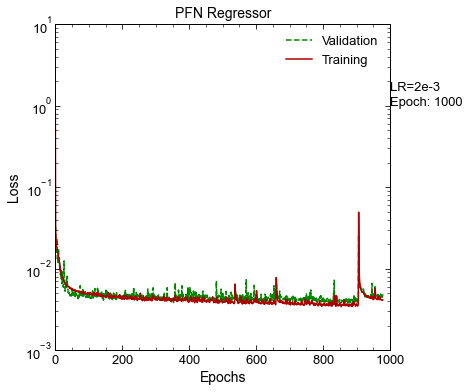

In [8]:
fig = plt.figure(figsize=(6,6))
plt.plot(pfn_loss['val_loss'], label="Validation",linestyle='dashed')
plt.plot(pfn_loss['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1000)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=2e-3', fontsize=13)
plt.text(1000, 1, 'Epoch: 1000', fontsize=13)
plt.title('PFN Regressor', fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

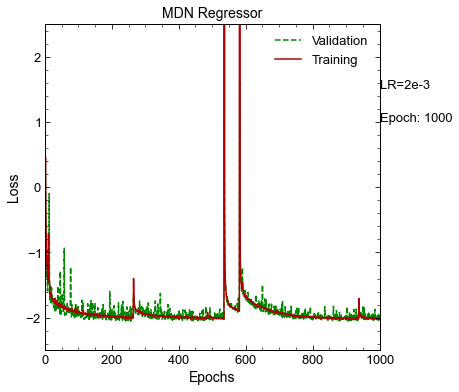

In [14]:
fig = plt.figure(figsize=(6,6))
plt.plot(MDN_loss['val_loss'], label="Validation",linestyle='dashed')
plt.plot(MDN_loss['loss'], label="Training")
plt.ylim(-2.5,2.5)
plt.yticks(fontsize=13)
plt.xlim(0,1000)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=2e-3', fontsize=13)
plt.text(1000, 1, 'Epoch: 1000', fontsize=13)
plt.title('MDN Regressor', fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [8]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

In [9]:
import tensorflow_probability as tfp

In [10]:
def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features, name="PFN_MDN_Network"):
    
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)

In [14]:
Kb.clear_session()

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

PFN_mdn = ParticleFlow_MDN(num_features=5)
PFN_mdn.compile(optimizer = netOpt, loss=lambda y, p_y: -p_y.log_prob(y))
PFN_mdn.summary()

Model: "PFN_MDN_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, None, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, None, 100)    10100       activation_0[0][0]               
____________________________________________________________________________________

In [15]:
%%capture output
model_name = 'pfn_mdn_regressor_1'
chkpoint = tf.keras.callbacks.ModelCheckpoint('model/' + model_name + '.h5', monitor='val_loss', verbose=1, save_best_only=True)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)

# save history to csv, or to npy later, in order to plot comparison of multiple training runs
history_logger = tf.keras.callbacks.CSVLogger('log/' + model_name + '.log', separator=',', append=True)

# back up
# backup  = tf.keras.callbacks.BackupAndRestore(backup_dir="backup")

t0 = t.time()
history_ct = PFN_mdn.fit(data_generator(data, target, batch_size=1024),
        epochs=1000,
        steps_per_epoch=len(data)//1024,
        validation_data=data_generator(val_data, val_target, batch_size=800),
        validation_steps=len(val_data)//800,
        verbose=1,
        callbacks=[chkpoint,history_logger])
t1 = t.time()

In [ ]:
pfn_history = np.load(ext_modelpath + 'pfn_regressor_3f_1.log.npy',allow_pickle='TRUE').item()

In [ ]:
np.save('PFN_MDN_regressor_weight_nl.log.npy',history_ct.history)

In [ ]:
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str((t1-t0)/60)+' (m)')